#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles

from tqdm import tqdm

In [2]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

#### Create datasets

In [4]:
nTot = 20
circles_data, circles_labels = make_circles(n_samples = nTot)

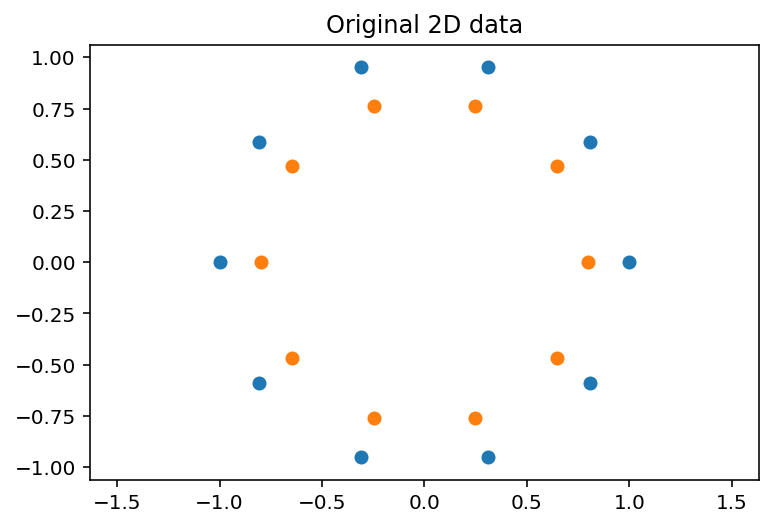

In [5]:
idx_0 = np.where(circles_labels==0)
idx_1 = np.where(circles_labels==1)
plt.scatter(circles_data[idx_0,0],circles_data[idx_0,1])
plt.scatter(circles_data[idx_1,0],circles_data[idx_1,1])
plt.axis('equal')
plt.title('Original 2D data')
plt.show()

#### Split into train and test

In [6]:
fracTrain = 0.8
fracTest = 1 - fracTrain

nTrain = int(nTot*fracTrain)
nTest = nTot - nTrain

In [7]:
repsTrain_solo = circles_data[:nTrain]
repsTest_solo = circles_data[nTrain:]

labelsTrain = circles_labels[:nTrain].astype(float)
labelsTest = circles_labels[nTrain:].astype(float)

In [8]:
dimProj = 100
A = np.random.rand(2,dimProj)

repsTrain_proj = repsTrain_solo@A
repsTest_proj = repsTest_solo@A

#### Convert data to tensors

In [9]:
dataTrain = Variable(torch.from_numpy(repsTrain_proj)).requires_grad_(True)
yTrain = Variable(torch.from_numpy(labelsTrain)).requires_grad_(True)

dataTest = Variable(torch.from_numpy(repsTest_proj)).requires_grad_(True)
yTest = Variable(torch.from_numpy(labelsTest)).requires_grad_(True)

#### Train and test loaders

In [10]:
## create dataset and dataloader
tensorTrainData = TensorDataset(dataTrain,yTrain)
tensorTestData = TensorDataset(dataTest,yTest)

bs = 2 ## batch size
train_loader = DataLoader(tensorTrainData, batch_size=bs, shuffle=True)
train_loader_noShuffle = DataLoader(tensorTrainData, batch_size=bs, shuffle=False)
test_loader = DataLoader(tensorTestData, batch_size=bs, shuffle=False)

#### Test for CUDA

In [11]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
else:
    print('GPU found, training on GPU')

GPU found, training on GPU


#### MLP AE

In [12]:
n_latent = 50

In [13]:
class MLPAE(nn.Module):
    def __init__(self):
        super(MLPAE, self).__init__()
        
        ##Encoder
        self.layer1 = nn.Linear(100,50,bias=False)
        self.layer2 = nn.Linear(50,50,bias=False) ## latent layer ##R1
        self.layer3 = nn.Linear(50,50,bias=False) ##R2
        self.layer4 = nn.Linear(50,100,bias=False) ## recon layer
        
        self.dropout = nn.Dropout(0.0)
        
        
    def forward(self, x):
        
        def firing_rate(x):
            nSamp, nNodes = x.shape
            firing_rate_mat = torch.zeros(nSamp,nNodes)
            keep_idxs = torch.argsort(x,dim=1)[:,:20]
            for kk in range(nSamp):
                firing_rate_mat[kk,keep_idxs[kk]] = 1
            return firing_rate_mat
        
        ## layer 1
        frIn = firing_rate(x)
        
        x = F.relu(self.layer1(x))
        frL1 = firing_rate(x)
        
        x = F.relu(self.layer2(x))
        frL2 = firing_rate(x)
        
        x_latent = self.dropout(x)
        x = F.relu(self.layer3(x))
        frL3 = firing_rate(x)
       
        x_recon = self.layer4(x)
        frOut = firing_rate(x_recon)
        
        return x_recon, frIn, frL1, frL2, frL3, frOut, x_latent

#create the NN
model = MLPAE()
print(model)

#move tensors to GPU if available
if train_on_gpu:
    model.cuda()

MLPAE(
  (layer1): Linear(in_features=100, out_features=50, bias=False)
  (layer2): Linear(in_features=50, out_features=50, bias=False)
  (layer3): Linear(in_features=50, out_features=50, bias=False)
  (layer4): Linear(in_features=50, out_features=100, bias=False)
  (dropout): Dropout(p=0.0, inplace=False)
)


#### Count number of parameters

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

15000

#### Trial pass for MLPAE

In [15]:
for data, target in train_loader:
    if train_on_gpu:
        data, target = data.float().cuda(), target.float().cuda()
        reconTP, frInTP, frL1TP, frL2TP, frL3TP, frOutTP, latentTP = model(data)

In [16]:
bsize, dimIn = frInTP.shape
_, dim1 = frL1TP.shape
_, dim2 = frL2TP.shape
_, dim3 = frL3TP.shape
_, dimOut = frOutTP.shape

In [17]:
# frOutTP.shape

#### Define updater network

In [18]:
class Updater(nn.Module):
    def __init__(self):
        super(Updater, self).__init__()
        
        ##Encoder
        self.layer1 = nn.Linear(2,2)
        self.layer2 = nn.Linear(2,1)
        
        self.dropout = nn.Dropout(0.0)
        
    def forward(self, x):
        
        ## layer 1
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.tanh(self.layer2(x))
        
        return x

#create the NN
updater = Updater()
print(updater)

#move tensors to GPU if available
if train_on_gpu:
    updater.cuda()

Updater(
  (layer1): Linear(in_features=2, out_features=2, bias=True)
  (layer2): Linear(in_features=2, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)


In [19]:
count_parameters(updater)

9

#### Trial pass for updater 

In [20]:
# i1 = 0
# j1 = 0

# xx = torch.cat((frInT[:,i1].view(-1,1),frL1T[:,j1].view(-1,1)),1)
# if train_on_gpu:
#     xx = xx.cuda()
# print(xx.shape)

In [21]:
# oo = updater(xx)
# torch.mean(oo,0)[0]

In [22]:
def deltaW(di,dj,fri,frj,upM,GPU):
    dw = torch.zeros(dj,di)
    for ii in range(di):
        for jj in range(dj):
            frBatch = torch.cat((fri[:,ii].view(-1,1),frj[:,jj].view(-1,1)),1)
            if GPU:
                frBatch, dw = frBatch.cuda(), dw.cuda()
            dw[jj,ii] = torch.mean(upM(frBatch),0)[0]
    return nn.Parameter(dw)

In [23]:
# dwsL1 = deltaW(dimIn,dim1,frInTP,frL1TP,updater,train_on_gpu)
# dwsL4 = deltaW(dim3,dimOut,frL3TP,frOutTP,updater,train_on_gpu)

In [24]:
# dwsL4.shape

In [25]:
# oldClone = model.layer1.weight.clone()
# oldClone += (dwsL12)
# model.layer1.weight = nn.Parameter(oldClone)

In [26]:
def updateSynapses(bigModel,updaterModel,dims,firingRates,GPU):
        
#     recon, frIn, frL1, frL2, frL3, frOut, latents = bigModel(batchData)
    
#     bsize, dimIn = frIn.shape
#     _, dim1 = frL1.shape
#     _, dim2 = frL2.shape
#     _, dim3 = frL3.shape
#     _, dimOut = frOut.shape

    frIn, frL1, frL2, frL3, frOut = firingRates

    dimIn, dim1, dim2, dim3, dimOut = dims
        
    ## layer1
    clone1 = bigModel.layer1.weight.clone()
    clone1 += deltaW(dimIn,dim1,frIn,frL1,upM=updaterModel,GPU=GPU)
    bigModel.layer1.weight = nn.Parameter(clone1)
        
    ## layer2
    clone2 = bigModel.layer2.weight.clone()
    clone2 += deltaW(dim1,dim2,frL1,frL2,upM=updaterModel,GPU=GPU)
    bigModel.layer2.weight = nn.Parameter(clone2)
    
    ## layer3
    clone3 = bigModel.layer3.weight.clone()
    clone3 += deltaW(dim2,dim3,frL2,frL3,upM=updaterModel,GPU=GPU)
    bigModel.layer3.weight = nn.Parameter(clone3)
    
    ## layer4
    clone4 = bigModel.layer4.weight.clone()
    clone4 += deltaW(dim3,dimOut,frL3,frOut,upM=updaterModel,GPU=GPU)
    bigModel.layer4.weight = nn.Parameter(clone4)
    
    bigModel = bigModel.eval()
    
    return bigModel

#### Loss function and optimizer

In [27]:
#specify loss function
criterion = nn.MSELoss()

#optimizer
eta = 0.001
optimizer = torch.optim.Adam(updater.parameters(), lr=eta)

#### Addresses to collect activations and models

In [28]:
pp = 'C:/Users/abalwani6/Desktop/Spring 2021/Classes/CS 8803 CAB/Final-Project/'
npp = 'saved-models-hebbian-MLPAE/'
pp_npy = pp+npp+'npys/'
pp_pts = pp+npp+'pts/'

#### Train updater model

In [29]:
dimsList = [dimProj,n_latent,n_latent,n_latent,dimProj]

In [30]:
#number of epochs
n_epochs = 4
div = n_epochs//4 ## try ensuring that number used to divide by is a factor of n_epochs
train_losses = np.zeros(n_epochs)

train_loss_min = np.Inf
best_epoch = 0

for epoch in tqdm(range(1,n_epochs+1)):
    train_loss = 0.0
    cnt = 0
    
    #train updater model
    updater.train()
    model.eval()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.float().cuda(), target.float().cuda()
        
        optimizer.zero_grad() #clears older gradients
        recon_train, frIn_train, frL1_train, frL2_train, frL3_train, frOut_train, latents_train = model(data) #forward pass
        loss = criterion(recon_train,data) #calculate the loss for the batch on meta-objective
        loss.backward() #backprop
        optimizer.step() #update parameters in direction of the -ve gradient
        train_loss += loss.item()*data.size(0) #update training loss
        
        firingRates_tup = (frIn_train, frL1_train, frL2_train, frL3_train, frOut_train)
        
        model = updateSynapses(model,updater,dimsList,firingRates_tup,train_on_gpu) ##update synapses of the main model
        
    #calculate average loss
    train_loss = train_loss/len(train_loader.dataset)
    
    #training/validation stats
#     print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    train_losses[epoch-1] = train_loss
    
    #save model if the training loss decreased
    if train_loss <= train_loss_min:
        print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
        torch.save(model.state_dict(),pp_pts+'hebbian-MLPAE.pt')
        torch.save(updater.state_dict(),pp_pts+'NN-updater.pt')
        train_loss_min = train_loss
        best_epoch = epoch
        
    if epoch%div == 0:
        torch.save(model.state_dict(), pp_pts+'hebbian-MLPAE_epoch_'+str(epoch)+'.pt')
        torch.save(updater.state_dict(), pp_pts+'NN-updater_epoch_'+str(epoch)+'.pt')
        
        activations_hidden_np = np.zeros((nTest,n_latent))
        
        activations_out_np = np.zeros((nTest,dimProj))
        
        # track test loss
        test_loss = 0.0
        
        model.eval()
        updater.eval()
        for data_test, target_test in test_loader:
            if train_on_gpu:
                data_test, target_test = data_test.float().cuda(), target_test.float().cuda()
            
            ## outputs
            output_test, frIn_test, frL1_test, frL2_test, frL3_test, frOut_test, latents_test = model(data_test)
            
            # calculate the batch loss
            loss = criterion(output_test,data_test)
            
            # update test loss 
            test_loss += loss.item()*data_test.size(0)
            
            latents_test = np.squeeze(latents_test.detach().cpu().numpy())
            output_test = np.squeeze(output_test.detach().cpu().numpy())
            
            for i in range(bs):
                if i < len(data_test):
                    label = target_test.data[i]

                    activations_hidden_np[cnt] = latents_test[i]

                    activations_out_np[cnt] = output_test[i,-1]

                    cnt += 1

        np.save(pp_npy+'hebbian-MLPAE_latent_epoch_'+str(epoch), activations_hidden_np)
        
        np.save(pp_npy+'hebbian-MLPAE_out_epoch_'+str(epoch), activations_out_np)
        
        # average test loss
        test_loss = test_loss/len(test_loader.dataset)
        print('Test Loss: {:.6f}\n'.format(test_loss))

 25%|██▌       | 1/4 [00:45<02:17, 45.78s/it]

Epoch: 1, Train Loss Decreased!! (inf-->0.277696)
Test Loss: 0.235676



 50%|█████     | 2/4 [01:31<01:31, 45.84s/it]

Epoch: 2, Train Loss Decreased!! (0.277696-->0.277295)
Test Loss: 0.235676



 75%|███████▌  | 3/4 [02:19<00:46, 46.44s/it]

Test Loss: 0.235676



100%|██████████| 4/4 [03:05<00:00, 46.25s/it]

Epoch: 4, Train Loss Decreased!! (0.277295-->0.277295)
Test Loss: 0.235676



Text(0, 0.5, 'MSE')

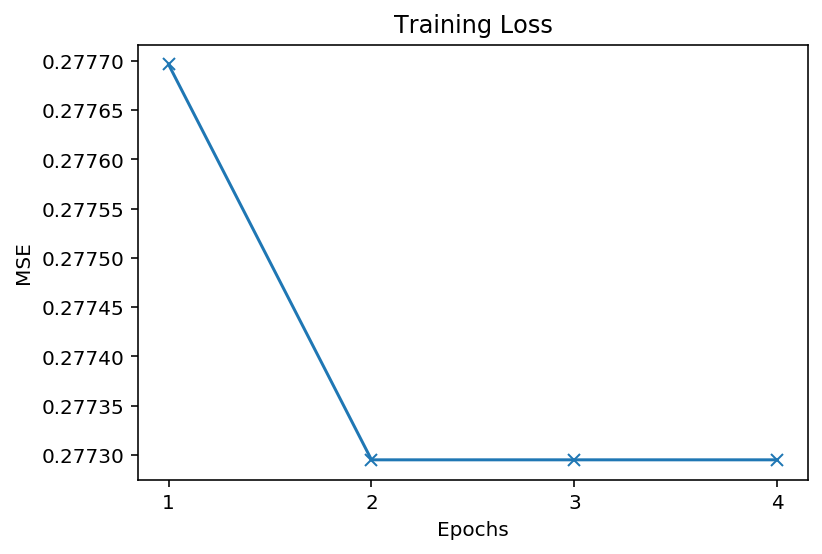

In [31]:
plt.plot((train_losses),'-x')
plt.xticks(np.arange(n_epochs),np.arange(n_epochs)+1)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')

#### Load best models